<a href="https://colab.research.google.com/github/freha-mezzoudj/NLP_US_Airlines_tweets/blob/main/DL_Algorithms_US_Airlines_3Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning_US Airlines Tweets Sentiment 3_Classes**

Twitter data for US_Airlines was scraped from February of 2015. The Kaggle contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The information of **main** attributes (from 15) for this project as follows;

1. alirline_sentiment : Sentiment classification.(positivie, neutral, and negative)

2. negativereason : Reason selected for the negative opinion

3. airline : Name of 6 US Airlines('Delta', 'United', 'Southwest', 'US Airways', 'Virgin America', 'American')

4. text : Customer's opinion

**Importing Libraries & Loading Data**

In [32]:
#starting by importing the necessary libraries
import numpy as np #The library that handles all the numbers and matrices
import pandas as pd # This library is for reading and manipulating the data, can do a lot of things
import matplotlib.pyplot as plt #for data visualization 

from sklearn.naive_bayes import MultinomialNB #mainly based on bayes theorem; not complicated but has its advantages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression #The most simple classifier
#ensemble models are worth trying 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier #although it does not need training but still brilliant
from sklearn.svm import SVC #most popular machine learning classifier 
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score #for accuracy and scores


**Reading the data**

In [33]:
from google.colab import drive

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
os.chdir("/content/drive/My Drive/data")

In [36]:
#loading the US Airline Sentiment data
df = pd.read_csv('Tweets2.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#df.shape

(14640, 15)

**EDA**

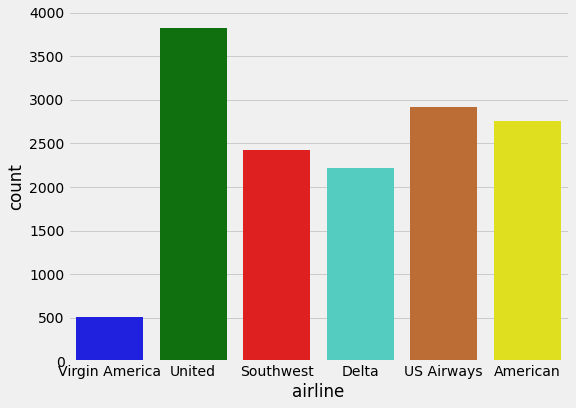

In [46]:
# Unique values of airline

col = ['blue', 'green', 'red', 'turquoise', 'chocolate', 'yellow']
plt.figure(figsize=(8,6))
ax = sns.countplot(x="airline", data=df, palette = col)

Next time I am flying either with Virgin or Delta airlines, but definitely not with the US Airways. Looking on the brught side, we will show the numbers of each type of review for each line in the next graph.

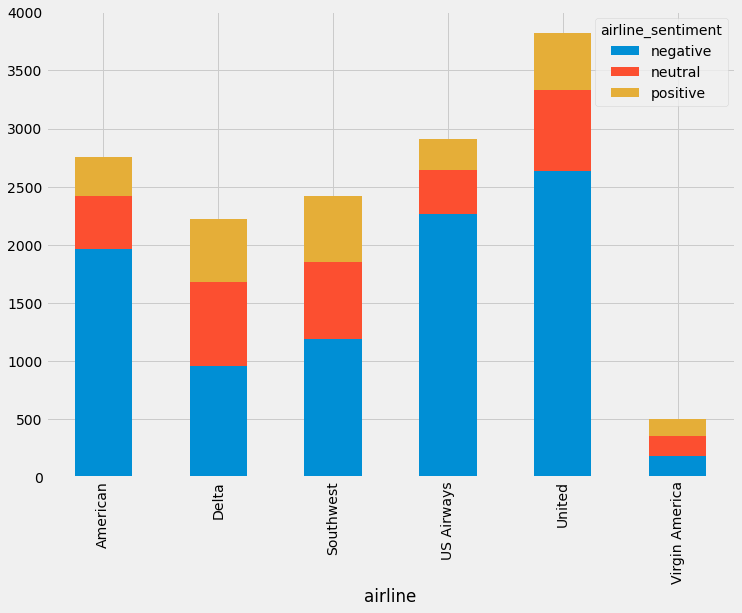

In [42]:
figure_2 = df.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(11,8))

In [49]:
print(figure_2)

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
dtype: int64


### **Tweets Preprocessing**

Basic Text Pre-Processing

Text preprocessing steps include a few essential tasks to further clean the available text data. It includes tasks like:-

Stop-Word Removal : In English words like a, an, the, as, in, on, etc. are considered as stop-words so according to our requirements we can remove them to reduce vocabulary size as these words don't have some specific meaning

Lower Casing : Convert all words into the lower case because the upper or lower case may not make a difference for the problem. And we are reducing vocabulary size by doing so.

Stemming : Stemming refers to the process of removing suffixes and reducing a word to some base form such that all different variants of that word can be represented by the same form (e.g., “walk” and “walking” are both reduced to “walk”).

Tokenization : NLP software typically analyzes text by breaking it up into words (tokens) and sentences

In [52]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    #some words might give us something important for the sentiment analysis like not, so we keep them
    wl = ["not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in wl) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'@\w+', '', input_text[i])
    return input_text

def lower_case(input_text):
    for i in range(len(input_text)):
        input_text[i] = input_text[i].lower()
    return input_text

def remove_http(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'http\S+', '',input_text[i])
    return input_text

def remove_punctuation(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'[^\w\s]','',input_text[i])
    return input_text

In [54]:
data_2 = df[['text', 'airline_sentiment']]
preprocessed_data = data_2.apply(remove_mentions).apply(remove_http).apply(remove_punctuation).apply(lower_case)
clean_text = []
for tweet in preprocessed_data.text:
    clean = remove_stopwords(tweet)
    clean_text.append(clean)

X = clean_text
Y = preprocessed_data['airline_sentiment']
from sklearn.model_selection import train_test_split
Y = Y.map({'negative':0, 'positive':1, 'neutral':2}).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

Word Representation

Word representation is an important stage in natural language processing (NLP), and the move from one hot encoders to more efficient and meaningful word representations enhanced the performance of NLP models.

In a paper published in 2019, researchers from CMU and facebook attempted to do sentence classification without training the encoders and relying only on pretrained embeddings, and it achieved pretty good results, the paper. In this section, we will explore different word representation techniuqes.

Term frequency-inverse document frequency (TF-IDF) has emerged to be a powerful word representation technique until today,

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
text_features_train = vectorizer.fit_transform(X_train)
text_features_test = vectorizer.transform(X_test)

Another breakthrough in the field of NLP is Word2vec, proposed by google. It gives word representation based on the context of the word. On the other hand, it has some limitations like the out of vocab, but since we are using a small dataset, it will not be an issue now. The following code train a word2vec model on our data, and you can also download pretrained word2vec embeddings for many languages.

In [56]:
from gensim.models import Word2Vec
sentences = [line.split() for line in clean_text]
w2v = Word2Vec(sentences, size=50, min_count = 0, window = 5,workers=4,iter=500)

visualization of what word2vec actually learn, you can notice that words that are similar are actually close in the space

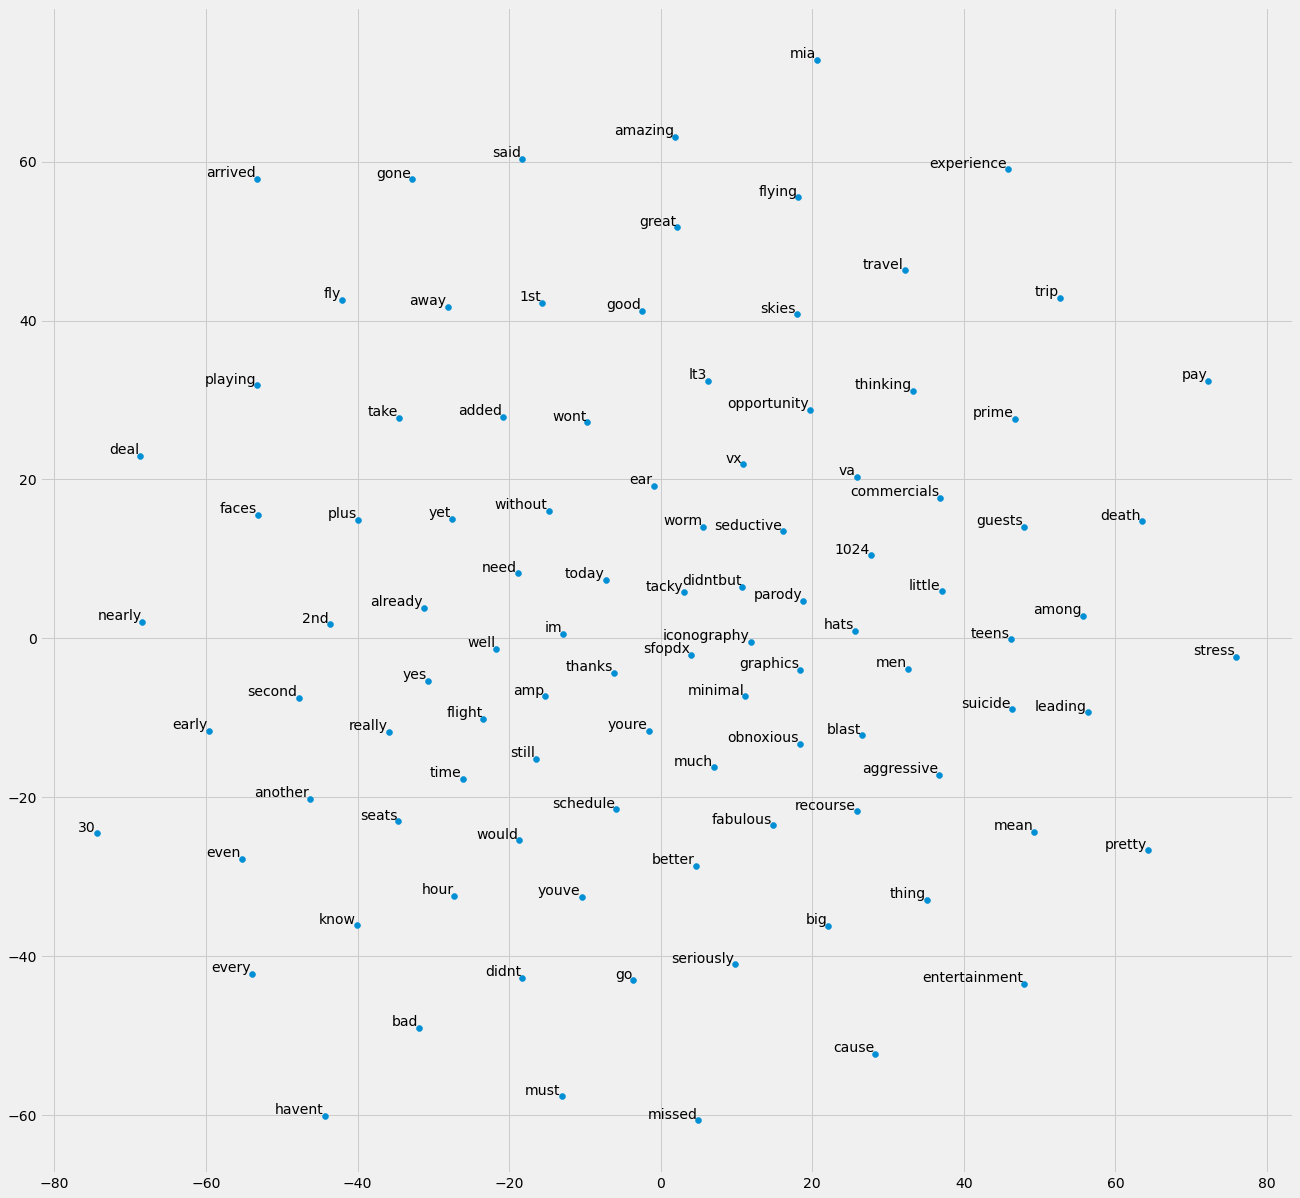

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X = w2v[w2v.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[0:100])
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
labels = list(w2v.wv.vocab.keys())
for label, x, y in zip(labels, X_tsne[:, 0], X_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, -1),
        textcoords='offset points', ha='right', va='bottom')

plt.show()

For DL Algorithms, every word should be replaced by a token, and stored in a dictionary that holds for every word its embeddings.

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

t = Tokenizer()
t.fit_on_texts(clean_text)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(clean_text)
padded_docs = pad_sequences(encoded_docs, maxlen=20, padding='post')
embedding_dict = dict()
for i in w2v.wv.vocab:
    embedding_dict[i] = w2v[i]

embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

After **word2vec**, companies and universities entered a competetion in the field of word embeddings, facebook proposed fastText that overcomes the issue of out of vocabulary. 

However, Samsung with the University of edingburgh proposed **Byte Per Encoding** (BPE).

Researchers made another contexual word embeddings (this was also a limitation in word2vec that it does not take into consideration that words may have multiple meanings) by proposing **Elmo**.

# **Tweets - Sentiments Classification tasks**

For **ML**, the use of TF-IDF as word representation is more adequate. ML algorithms which can be used Logistic regression, Support Vector Machines (SVM), Naiive Bayes, Gradient Boosting, Random Forest and so on.

From the **DL** techniques we will explore the feed forward neural network (**MLP**), Long Short Term Memory (**LSTM**), and convolutional Neural Networks (**CNN**) for text classification. 

For **DL**, at first, the labels should be in the form of one hot encoders, then the embeddings extracted by word2vec will be used.



In [59]:
import tensorflow as tf
y_one_hot = tf.keras.utils.to_categorical(
    Y,
    num_classes=3,
    dtype='int32'
)

In [60]:
x_train_DL, x_test_DL,y_train_DL,y_test_DL = train_test_split(padded_docs,y_one_hot,test_size=0.1,random_state=42)

**Feed Forward Neural Networks**

Feed Forward neural networks can perform solid classifications given moderate amount of data. In this model, we will use the trained word2vec embeddings as the initialized embeddings for the first layer, followed by two dense layers each containing 128 hidden nodes, in addition to dropout to reduce the effect of overfitting. finally, softmax actiavtion is used to predict the most probable output.

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from sklearn.metrics import accuracy_score
model = Sequential()
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=False)
model.add(embedding_layer)
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
model.fit(x_train_DL,y_train_DL,epochs = 50, batch_size=128)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)
acc_test = accuracy_score(ans,labels)
print('\n Accuracy_test  : {:.4f}'.format(acc_test))


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 50)            726400    
                                                                 
 dense_19 (Dense)            (None, 20, 128)           6528      
                                                                 
 dropout_14 (Dropout)        (None, 20, 128)           0         
                                                                 
 dense_20 (Dense)            (None, 20, 128)           16512     
                                                                 
 dropout_15 (Dropout)        (None, 20, 128)           0         
                                                                 
 flatten_6 (Flatten)         (None, 2560)              0         
                                                                 
 dense_21 (Dense)            (None, 3)                

acc: 0.7800546448087432

**Long Short Term Memory (LSTM)**

The need for **recurrent neural network** is important, but they still suffered from the vanishing gradients problem, which in turn led researchers to propose Gated recurrent Unit (**GRU**) and **LSTM**, which are better at caputring the meaning of a whole sequence. 

In [71]:
model = Sequential() 
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=True)
model.add(embedding_layer)
model.add(LSTM(32, activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation = 'softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_DL,y_train_DL,epochs = 20,batch_size=256)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)
acc_test = accuracy_score(ans,labels)
print('\n Accuracy_test  : {:.4f}'.format(acc_test))


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 50)            726400    
                                                                 
 lstm_2 (LSTM)               (None, 20, 32)            10624     
                                                                 
 dropout_16 (Dropout)        (None, 20, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 3)                 99        
                                                                 
Total params: 745,443
Trainable params: 745,443
Non-tr

acc: 0.7670765027322405

Conolutional Neural Networks (**CNN**)

CNN are used in the tasks of image processing, but they also perform pretty good in the field of NLP. In fact, in machine translation, facebook proposed CNN, and it is considered one of the state of the art architectures, as they achieved high results on all the bench marks and actually they are leading in some languages. Also, they are well known for their ability of parallel computation.

In [ ]:
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers import Dropout
model = Sequential()
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=False)
model.add(embedding_layer)
model.add(Convolution1D(nb_filter=100,
                        filter_length=3,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_DL,y_train_DL,epochs=20)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)

acc_test = accuracy_score(ans,labels)
print('\n Accuracy_test  : {:.4f}'.format(acc_test))


acc: 0.7206284153005464

There is a problem to edit the val. acc. of my NN models ???